# **Gender Equity at the Tokyo Olympics**

The International Olympic Committee touted the 2020 Tokyo Games as the "[first gender-balanced Games in history](https://olympics.com/ioc/news/tokyo-2020-first-ever-gender-balanced-olympic-games-in-history-record-number-of-female-competitors-at-paralympic-games)" with women composing 49% of participants. Although its statement described the total gender makeup of the Games, I wondered if differences still existed within teams for certain countries or events. Thus, I set out to understand the true nature of gender equity at the Tokyo Olympics.

## **Part I. Creating the data set**

To explore my question, I needed to retrieve the pertinent information from the official Olympics website. Of interest was the "Olympic Medal Count" table, which contained each country's final ranking based on how many medals they earned over the course of the Games. Clicking on a country's name in the table took me to a page with specific entries for that NOC, including the participants for each event (called a discipline) categorized by males, females, and total athletes. I wrote the following code to scrape this data from each country's page:

In [33]:
# Import libraries to be used
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Url of the page that we want to scrape
url = "https://olympics.com/tokyo-2020/olympic-games/en/results/all-sports/medal-standings.htm"

# Send a request to the server to retrieve the page's html
r = requests.get(url)

soup = BeautifulSoup(r.text, 'lxml')

In [34]:
# Isolate the main medal standing table
table = soup.find('table', id = 'medal-standing-table')

# Get the link to each country's page from the table
links = table.find_all('a', class_ = 'country')

# Result is a shortened file path such as "../../../en/results/all-sports/noc-entries-united-states.htm"
# We need to restore the rest of the url through the following steps

url_lib = []

for link in links:
    link_ending = link.get('href').strip("/.")
    new_link = "https://olympics.com/tokyo-2020/olympic-games/" + link_ending
    url_lib.append(new_link) 
# Now the complete url to each country's page is stored in url_lib

In [ ]:
# Store the names of all countries in a separate list
country_names = [i.text.strip() for i in links]

In [49]:
import time

# Based on initial inspection, we want to get this information
headings = ["Country", "Discipline", "Athletes_F", "Atheltes_M", "Athletes_Total"]

# Create a Pandas dataframe with the above headings as columns
df = pd.DataFrame(columns = headings)

# Scrape each country's page
for url in url_lib:
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'lxml')
    table = soup.find('table', class_ = 'table table-schedule')

    # Remember country's position in the list of urls
    idx = url_lib.index(url)

    # Loop through each discipline in which the country competed
    for tr in table.find_all('tr')[1:-2]: # Careful to exclude the footer row

        # Get the discipline name
        discipline = tr.find('th').text.strip()
        # Get the athlete breakdown for the discipline: female, male, and total
        athletes = tr.find_all('td')
        athletes = [i.text.strip() for i in athletes]

        # Combine these items into one list
        athletes.insert(0, discipline)

        # Assign country's name to the beginning of the list
        athletes.insert(0, country_names[idx])

        # Return number of rows already in data frame
        length = len(df)

        # Store the list as a new row
        df.loc[length] = athletes

    # Access the table footer 
    footer = table.find('tfoot').find('tr')

    # Get total size of the country's competing team
    totals = footer.find_all('td')
    totals = [i.text.strip() for i in totals]
    totals.insert(0, country_names[idx])

    length = len(df)
    df.loc[length] = totals

    # Delay next page request by 10 sec
    time.sleep(10)

In [4]:
# Export final dataframe as csv file
df.to_csv('olympicsdata.csv')

## **Part II. Exploratory analysis**

After compiling my data, I used Matplotlib to build charts and visualize the relationship between different columns.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Import the csv file created previously
data = pd.read_csv('olympicsdata.csv')
# Remove extra index column
del data["Unnamed: 0"]
data.head()

,Country,Discipline,Athletes_F,Athletes_M,Athletes_Total
0,United States of America,3x3 Basketball,4,0,4
1,United States of America,Archery,3,3,6
2,United States of America,Artistic Gymnastics,6,5,11
3,United States of America,Artistic Swimming,2,0,2
4,United States of America,Athletics,65,63,128


In [3]:
# Subset the data to rows containing each country's total team size (not separated by discipline)
totals = data[data["Discipline"] == "Total"]
totals.head()

,Country,Discipline,Athletes_F,Athletes_M,Athletes_Total
43,United States of America,Total,338,288,626
84,People's Republic of China,Total,288,125,413
130,Japan,Total,286,316,602
165,Great Britain,Total,205,178,383
203,ROC,Total,187,149,336


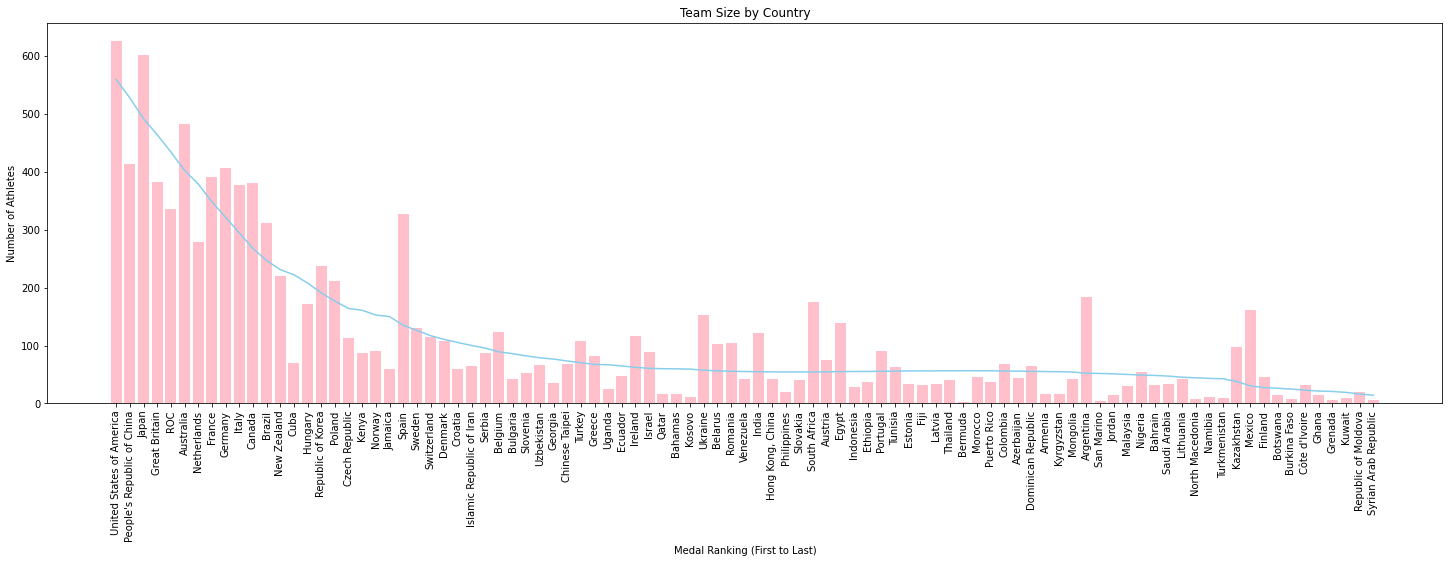

In [6]:
fig, axs = plt.subplots(figsize = (25,7))

# Plot a simple bar chart to display team size by country
plt.bar(totals["Country"], totals["Athletes_Total"], color="pink")

# Rotate x-axis labels from horizontal position to improve readability
plt.xticks(rotation=90)

# Label the plot
plt.title("Team Size by Country")
plt.xlabel("Medal Ranking (First to Last)")
plt.ylabel("Number of Athletes")

# Calculate a trend line with the following steps
import numpy as np

# May need to run this, if error: totals.reset_index(inplace=True)

# Convert columns from Pandas dataframe to Numpy array
country = totals["index"].to_numpy()
athletes = totals["Athletes_Total"].to_numpy()

# Fit a 4-degree polynomial to the data
z = np.polyfit(country, athletes, 4)
p = np.poly1d(z)

# Plot the trend line
plt.plot(totals["Country"], p(country), color="skyblue")

In the bar chart above, the countries are ordered left to right by their final medal standing. The United States, which placed 1st overall, had the largest combined team of over 600 athletes. China, which placed 2nd, seems to have had fewer participants than expected for the number of medals that it won, as its actual team size was about 100 athletes fewer than the trend line forecast.

In [24]:
# Get correlation between country medal standing and team size, using Numpy
r = np.corrcoef(country, athletes)
r[0,1]

-0.7789659835244189

The correlation coefficient, r = -0.78, suggests a strong negative association between the medal standing of a country and its team size. Countries that rank higher tend to have larger teams.

Next, I took a closer look at the breakdown of each country's athletes by gender.

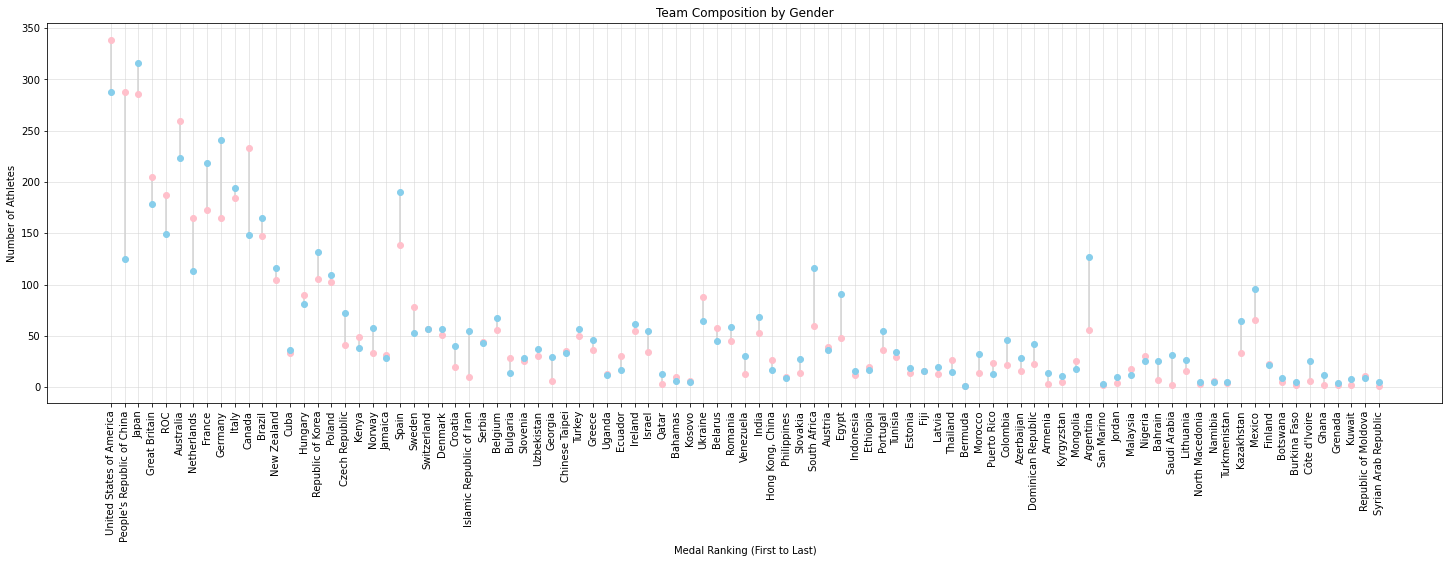

In [8]:
fig, axs = plt.subplots(figsize = (25,7))

# Create a lollipop chart with the following steps

# Plot dots for the number of male and female athletes competing on behalf of each country
axs.plot(totals['Country'], totals['Athletes_M'], marker="o", linewidth=0, color='skyblue')
axs.plot(totals['Country'], totals['Athletes_F'], marker="o", linewidth=0, color='pink')

# Before plotting the line chart, label each pair of dots
minimum = []
i = 0
while i < len(totals):
    # Store the smaller value in this list
    minimum.append(min(totals['Athletes_F'].iloc[i], totals['Athletes_M'].iloc[i]))
    i = i + 1
maximum = []
j = 0
while j < len(totals):
    # Store the larger value in this list
    maximum.append(max(totals['Athletes_F'].iloc[j], totals['Athletes_M'].iloc[j]))
    j = j + 1

# Now draw vertical lines from each smaller value to the larger value
plt.vlines(x=totals['Country'], ymin=minimum, ymax=maximum, color='lightgrey')

# Styling
plt.xticks(rotation=90)
plt.title("Team Composition by Gender")
plt.xlabel("Medal Ranking (First to Last)")
plt.ylabel("Number of Athletes")
plt.grid(color='lightgrey', linewidth=0.5)

plt.show()

In [8]:
# Correlation between team size and athlete genders, using Pandas
r_1 = totals["Athletes_F"].corr(totals["Athletes_M"])

# Between size of female athlete team and country medal ranking
r_2 = totals["Athletes_F"].corr(totals["index"])

# Between size of male athlete team and country medal ranking
r_3 = totals["Athletes_M"].corr(totals["index"])

print(r_1, r_2, r_3)

0.9147066692933614 -0.7895506158307973 -0.7324363884717217


In [32]:
disciplines = data.groupby(["Discipline"]).sum()
disciplines.reset_index(inplace=True)
disciplines = disciplines.drop([40]) # Drop 'Totals' row
disciplines.reset_index(inplace=True)

# Calculate each gender's participation per discipline
f = []
m = []
i = 0

while i < len(disciplines):
    f.append(disciplines['Athletes_F'][i]/disciplines['Athletes_Total'][i])
    m.append(disciplines['Athletes_M'][i]/disciplines['Athletes_Total'][i])
    i = i + 1
# Add columns to dataframe
disciplines = disciplines.assign(F_Ratio = f)
disciplines = disciplines.assign(M_Ratio = m)


Text(0, 0.5, 'Number of Athletes')

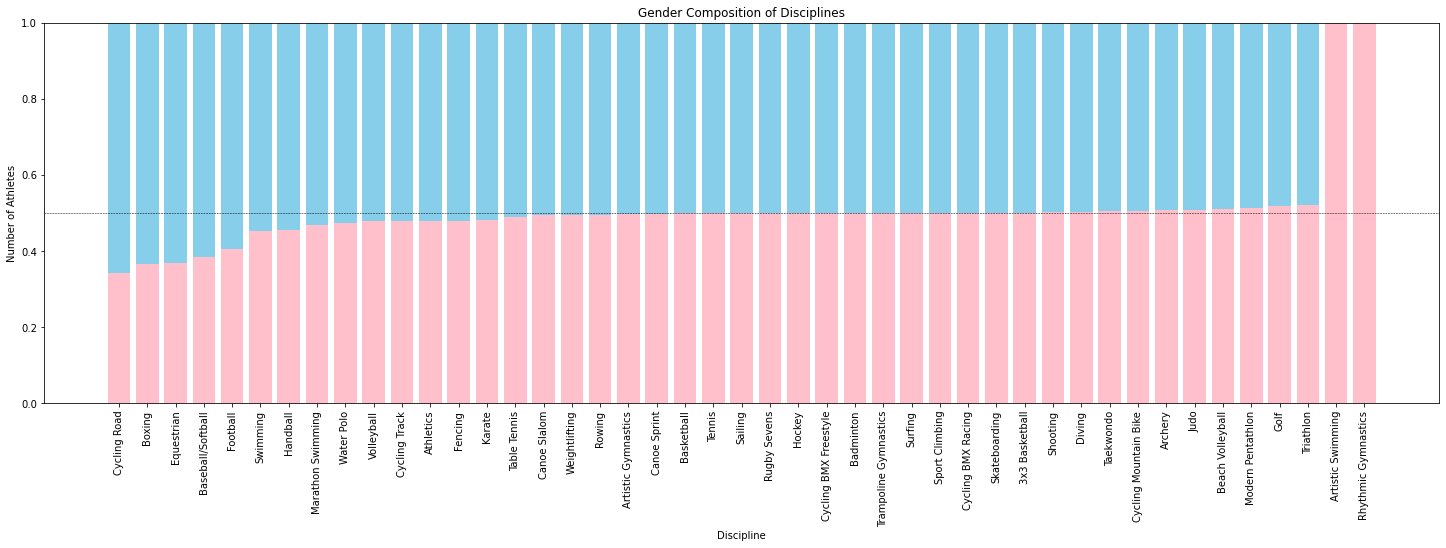

In [34]:
disciplines = disciplines.sort_values('F_Ratio')

fig, axs = plt.subplots(figsize = (25,7))
plt.bar(disciplines["Discipline"], disciplines["F_Ratio"], color="pink")
plt.bar(disciplines["Discipline"], disciplines["M_Ratio"], color="skyblue", bottom= disciplines["F_Ratio"])
axs.axhline(y=0.5, c="black", ls="--", lw="0.5")

plt.xticks(rotation=90)
plt.title("Gender Composition of Disciplines")
plt.xlabel("Discipline")
plt.ylabel("Number of Athletes")